Let's make a small test dataset first. We'll load the global countries layer, clip out the area around some of the following countries (see cell below):

- Benin (204)
- Togo (768)
- Ghana (288)
- China (156) (too large, crashes because of lack of memory…)
- India (356)
- Indonesia (360)

We'll use these to test performance on a subset of countries:

In [1]:
countries = [768,288,204]

 But first, load some modules:

In [2]:
from PIL import Image
from osgeo import gdal
import os, numpy as np
import csv
from scipy import signal

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,16]

Some constants we'll need:

In [3]:
ruralCell = 1
urbanCell = 2
topNcells = 50
MAJ = 'Major area, region, country or area'

# Factor to simulate densities in the highest density areas going down.
thinningFactor = 0.95

# number of top cells to take into account when calculating the average of the N cells with the highest population per country:
# TODO: Maybe this should be a % of all cells in a country, rather than a
# fixed number? E.g. 3%?
topNcells = 50

Load the data:

In [4]:
def openTIFFasNParray(file):
    src = gdal.Open(file, gdal.GA_Update)
    band = src.GetRasterBand(1)
    return np.array(band.ReadAsArray())

In [5]:
base = os.path.expanduser('~') + '/Dropbox/CISCdata/'

# load countries TIFF and convert to NumPy array
f = base + 'NationsRaster/ne_10m_admin_0_countries_updated_nibbled.tiff'
countryBoundaries = openTIFFasNParray(f)


Find the bounding box of our countries in there. We'll need that a few times, let's make it a function:

In [6]:
def findBoundingBox(a, values):

    """"Finds the min/max x and y values of the occurrence of any value from values with the 2D array a.
    Output can be directly used for clipping. Returns 4 values in the following order:
    1. minX
    2. maxX
    3. minY
    4. maxY"""
    
    inCountries = np.where(np.isin(a, values))

    minX = np.min(inCountries[0])
    maxX = np.max(inCountries[0]) + 1 # to include the last column!

    minY = np.min(inCountries[1])
    maxY = np.max(inCountries[1]) + 1 # to include the last row!
    
    return minX, maxX, minY, maxY

In [7]:
minX, maxX, minY, maxY = findBoundingBox(countryBoundaries, countries)

And use them to clip out the area of interest:

(920, 851)


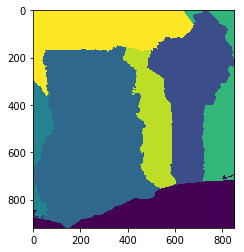

In [8]:
countryBoundaries = countryBoundaries[minX:maxX, minY:maxY]

shape = countryBoundaries.shape

print(shape)

# turn into 1D array for easier processing
countryBoundaries = countryBoundaries.ravel()

#only turn back into oringal shape for plotting/saving
plt.imshow(countryBoundaries.reshape(shape))
plt.show()

Repeat for the other datasets. First, population 2000:

(16920, 43200)


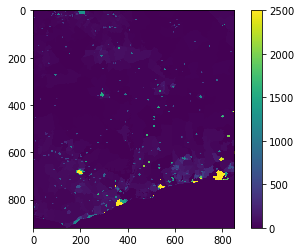

In [9]:
f = base + 'Population2000Raster/Pop_2000_clipped.tiff'
pop2000 = openTIFFasNParray(f)
print(pop2000.shape)

# clip
pop2000 = pop2000[minX:maxX, minY:maxY]

# we'll turn the floats into integers - no half people!
pop2000 = pop2000.astype(int)
pop2000 = pop2000.ravel()

#plot 
plt.imshow(pop2000.reshape(shape), clim=(0.0, 2500.0))
plt.colorbar()
plt.show()

Load the GRUMP urban/rural layer

(16920, 43200)


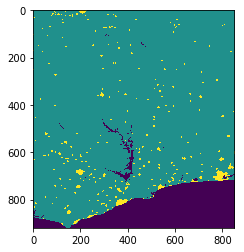

In [10]:
f = base + 'GLURRaster/GRUMP_UrbanRural.tiff'
urban = openTIFFasNParray(f)
print(urban.shape)

# clip + plot
urban = urban[minX:maxX, minY:maxY]

urban = urban.ravel()

plt.imshow(urban.reshape(shape))
plt.show()

Areas raster:

(16920, 43200)


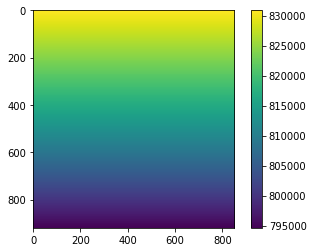

In [11]:
f = base + 'AreaGrid/area-grid.tif'
areas = openTIFFasNParray(f)

print(areas.shape)

# clip + plot
areas = areas[minX:maxX, minY:maxY]

areas = areas.ravel()

plt.imshow(areas.reshape(shape))
plt.colorbar()
plt.show()

That should be all the geodata we need. Let's load the population projection data. First, some functions:

In [12]:
def transposeDict(listOfDicts, pk):

    """Turns a list of dictionaries into a single one."""

    output = {}
    for dic in listOfDicts:
        output[dic[pk]] = dic
    return output


def getCountryByID(country, WTP):

    """Looks up the country name by UN ID."""

    try:
        return WTP[str(country)][MAJ]
    except KeyError:
        print("No country found for ID " + str(country))
        logging.error("No country found for ID " + str(country))
        return 0
    
def getNumberForYear(table, year, country):

    """Looks up the population number for a country in a given year from a table."""

    # CSVs have weird number formatting with blanks (thanks for nothing, Excel),
    # that's why we need the "replace" bit
    return int(table[str(country)][str(year)].replace(" ", ""))

Load total/urban population data for SSP3:

In [13]:
WTP = transposeDict(csv.DictReader(open(os.path.expanduser('~') + '/Dropbox/CISCdata/SSPs/pop-SSP3.csv')), "Country code")
WUP = transposeDict(csv.DictReader(open(os.path.expanduser('~') + '/Dropbox/CISCdata/SSPs/urbpop-SSP3.csv')), "Country code")

In [14]:
#WUP

In [15]:
for c in countries:
    print(getCountryByID(c, WTP))

Togo
Ghana
Benin


👍🏻

# On to the actual optimization! 🔧

Let's define some functions we'll use, one per block to keep it readable

In [16]:
def getTopNCells(N, arrrray):

    """Returns the highest N values from an array.
       Returns empty array if N=0."""

    p = np.partition(-arrrray, N)
    pp = -p[:N]

    return pp

## Big To-Do

The removeRandom function is going to need a way to pass probabilities to it, which is really tricky (or even impossible?) with this approach. See also my comment on https://stackoverflow.com/questions/43225076/iteratively-subtract-values-in-array.

In [17]:
# Removes "total" people from random cells in "array" without any of the cells becoming negative,
# using "probs" as probabilities for cells to be chosen to remove people from.
# Borrowed from https://stackoverflow.com/questions/43225076/iteratively-subtract-values-in-array

def removeRandom(array, total, probs=None):
    if total >= np.sum(array):
        return np.zeros_like(array)

    to_remove = total

    while to_remove != 0:
        idx = np.random.choice(range(len(array)), p=probs)

        removeable = min(array[idx], to_remove)

        array[idx] = array[idx] - removeable
        to_remove = to_remove - removeable

    return array

In [18]:
# Adding random people, heavily inspired by http://sunny.today/generate-random-integers-with-fixed-sum/
def addRandom(a, n, pvals=None):
    
    """Adds n people to random cells in a. 
    pvals allows to specify the probability of each cell to receive people.
    pvals has to be the same size as a and the values must add up to 1.0. 
    If pvals is not set, equal probablity for each cell is assumed."""
    
    if 'pvals' not in locals():
        pvals = [1/a.size]*a.size
        
    return np.add(a, np.random.multinomial(n, pvals, size=1)[0])

In [19]:
def makeWindow(n):
    
    """Generates an n x n 2D array to be used as a sliding window in the dissolve function. 
    All weights will be set to the same so that they add up to 1.0, execept for the center cell, which 
    will be set to 0.
    
    n is supposed to be an uneven number; if an even number is passed as an argument, an array of size
    n+1 x n+1 is generated
    """
    
    if n % 2 == 0:
        n = n+1

    sum = (n*n)
    out = np.repeat(1/(sum-1), sum).reshape(n,n)
    center = np.floor(n/2).astype(int)
    out[center,center] = 0.0
    return out

In [20]:
def dissolve(A, max, window_size=3, verbose=False):

    """Distributes population within a 2d-array A from cells above max to neighboring 
    cells based on a window array, which should be a square window with weights summing 
    up to 1.0, and 0 in the middle (the source cell), e.g.
    
    [[1/8., 1/8., 1/8.],
     [1/8., 0,    1/8.],
     [1/8., 1/8., 1/8.]]
     
     This is also the standard window being used if no window is provided.
     
     The verbose parameter can be used to have the function print the number of iterations 
     until all cells are below max.
     
     The process is repeated iteratively until no cells are above max any longer. 
     While larger and more complex windows actually slow things down, the standard 3x3 window
     may get stuck because people are basically moved back and forth between adjacent overpopulated cells.
     We therefore enlarge the window in every iteration if there is no improvement compared to the previous
     iteration.
     
     ⚡️ A needs to be a 2d array!
     ⚡️ Note that the function doesn't care whether a cell is in a given country, in the water,
     etc. So this may push people into the water or neighboring countries!
     ⚡️ Also note that because of border effects, the sum of the output array will almost always be
     (slightly) smaller than in the sum of the input array (unless the border cells in the input are all 0)
    """
    
    window = makeWindow(window_size)
    
    its = 0 # count iterations
    digits = 3 # how many digits to take into account when checking for progress on the maximum?
    lastmax = round(A.max(), digits) # keep track whether the max actually improves; we only care about 1 decimal place
                                # otherwise this keeps running forever with tiny improvements
    
    while((A.max() > max)): 
        its = its + 1
        
        if(verbose):
            print("Iteration " + str(its) + "; Current max: " + str(A.max()) + " (target: " + str(max) + ")")
        
        # keeps the numbers that are at or below the limit: (A<=max)*A
        # sets the numbers that are higher than max to max: (A>max)*max

        # this array contains all the values from the original one, but with those > max set to max:
        reduced = (( A <= max ) * A) + (( A > max ) * max)

        # the next one contains all the values beyond the max, and 0 everywhere else
        over    = ( A > max ) * ( A - reduced)

        # next, we'll use a sliding window on the "over" array to redistribute the people
        # and add them back to the "reduced" array
        A = reduced + signal.convolve2d( over, window, 'same' )
        
        if(round(A.max(), digits) >= lastmax):
            window_size = window_size+1
            window = makeWindow(window_size)
            
            if(verbose):
                print("Increasing window size to "+str(window_size))
            
        
        lastmax = round(A.max(), digits)
    
    if(verbose):
        print(str(its)+" iterations")
        
    return A


In [21]:
def adjustPopulationNew(popProj, year, country, WTP, WUP, urbanRural, areas):

    print("Running "+getCountryByID(country, WTP)+" ("+str(country)+")")
    
    
    # Adjust the density to thin out the densest areas a little bit. 
    # To do that, we need to perform couple of steps:

    
#     print("1. Put the countryBoundaries and popProj arrays back in 2D format, and")
#     print("2. clip out just the current country")
    minX, maxX, minY, maxY = findBoundingBox(countryBoundaries.reshape(shape), [country])
    thisPop = np.copy(popProj.reshape(shape)[minX:maxX,minY:maxY])
    thisCountry = countryBoundaries.reshape(shape)[minX:maxX,minY:maxY]
    
#     plt.imshow(thisPop)
#     plt.show()
#     plt.imshow(thisCountry)
#     plt.show()
    
    
#     print("3. in the subset, set the population OUTSIDE that country to 0:")
    thisPop[thisCountry != country] = 0
#     plt.imshow(thisPop)
#     plt.show()
    
    
#     print("4. thin out the densests areas:")
    thisPop = dissolve(thisPop, thisPop.max() * thinningFactor, verbose=True)
#     plt.imshow(thisPop)
#     plt.show()
    
    
#     print("5. round to 'whole' people")
    thisPop = np.rint(thisPop)
    
#     plt.imshow(thisPop)
#     plt.show()
    
    
#     print(" 6. paste the updated cells for this country back into the big population raster")
    popProj[countryBoundaries == country] = thisPop[thisCountry == country]
    
#     plt.imshow(popProj.reshape(shape))
#     plt.show()
    
    # 💥 TODO: ADD URBANIZATION STEP BEFORE WE START ADJUSTING!
    
    # figure out the difference between the popProj
    # input raster and what's in the table:

    u = urbanRural == urbanCell
    r = urbanRural == ruralCell
    i = countryBoundaries == country

    
    urbraster = np.nansum(popProj[np.all([i,u], axis=0)])
#     print("Urban raster: " + str(urbraster))
    rurraster = np.nansum(popProj[np.all([i,r], axis=0)])
#     print("Rural raster: " + str(rurraster))
    
    popcsv = getNumberForYear(WTP, year, country)
#     print("Pop csv:      " + str(popcsv))
    urbcsv = getNumberForYear(WUP, year, country)
#     print("Urban csv:    " + str(urbcsv))

    rurcsv = (popcsv - urbcsv)
#     print("Rural csv:    " + str(rurcsv))

    urbDiff = urbcsv - urbraster
#     print("Urban diff:   " + str(urbDiff))
    rurDiff = rurcsv - rurraster
#     print("Rural diff:   " + str(rurDiff))

    # calculate probabilities based on area:
    # these need to be of type np.float64, otherwise
    # we'll get rounding issues for very large countries and the
    # sum may go up beyound 1.0, causing an error!
    urbPval = areas[np.all([i,u], axis=0)].astype(np.float64)
    rurPval = areas[np.all([i,r], axis=0)].astype(np.float64)
    
    # normalize probabilities so the values add up to 1.0
    urbPval = urbPval/urbPval.sum(0)
    rurPval = rurPval/rurPval.sum(0)

    # adjust population to CSV values:
    # urban:
    if (urbDiff > 0):  # add people
        popProj[np.all([i,u], axis=0)] = addRandom(popProj[np.all([i,u], axis=0)], urbDiff, urbPval)
    else:   # remove people
        popProj[np.all([i,u], axis=0)] = removeRandom(popProj[np.all([i,u], axis=0)], urbDiff, urbPval)
    
    # rural:
    if (rurDiff > 0):  # add people
        popProj[np.all([i,r], axis=0)] = addRandom(popProj[np.all([i,r], axis=0)], rurDiff, rurPval)
    else:   # remove people
        popProj[np.all([i,r], axis=0)] = removeRandom(popProj[np.all([i,r], axis=0)], rurDiff, rurPval)


    urbraster = np.nansum(popProj[np.all([i,u], axis=0)])
#     print("Urban update: " + str(urbraster))
    rurraster = np.nansum(popProj[np.all([i,r], axis=0)])
#     print("Rural update: " + str(rurraster))
    urbDiff = urbcsv - urbraster
#     print("Urb diff upd:   " + str(urbDiff))
    rurDiff = rurcsv - rurraster
#     print("Rur diff upd:   " + str(rurDiff))
    
    # plot
    plt.imshow(popProj.reshape(shape), clim=(0.0, 2500.0))
    plt.colorbar()
    plt.show()
    
    # TODO: return the updated array!

Let's see whether that works and if it's faster than the old approach:

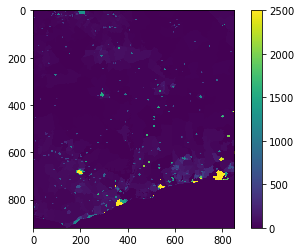

Running Togo (768)
Iteration 1; Current max: 3894 (target: 3699.2999999999997)
Iteration 2; Current max: 3893.625 (target: 3699.2999999999997)
Iteration 3; Current max: 3893.34375 (target: 3699.2999999999997)
Iteration 4; Current max: 3893.28125 (target: 3699.2999999999997)
Iteration 5; Current max: 3893.10400390625 (target: 3699.2999999999997)
Iteration 6; Current max: 3892.790399169922 (target: 3699.2999999999997)
Iteration 7; Current max: 3892.042919921875 (target: 3699.2999999999997)
Iteration 8; Current max: 3890.7623190402983 (target: 3699.2999999999997)
Iteration 9; Current max: 3889.0495993673803 (target: 3699.2999999999997)
Iteration 10; Current max: 3886.9848140887916 (target: 3699.2999999999997)
Iteration 11; Current max: 3884.5755435958504 (target: 3699.2999999999997)
Iteration 12; Current max: 3881.996763548127 (target: 3699.2999999999997)
Iteration 13; Current max: 3879.427666099125 (target: 3699.2999999999997)
Iteration 14; Current max: 3876.676588415402 (target: 3699.29

Iteration 116; Current max: 3715.4461004789578 (target: 3699.2999999999997)
Iteration 117; Current max: 3715.0569411789957 (target: 3699.2999999999997)
Iteration 118; Current max: 3714.677146027037 (target: 3699.2999999999997)
Iteration 119; Current max: 3714.3064909141417 (target: 3699.2999999999997)
Iteration 120; Current max: 3713.9447570020434 (target: 3699.2999999999997)
Iteration 121; Current max: 3713.5917306060533 (target: 3699.2999999999997)
Iteration 122; Current max: 3713.247203080082 (target: 3699.2999999999997)
Iteration 123; Current max: 3712.910970703771 (target: 3699.2999999999997)
Iteration 124; Current max: 3712.582834571736 (target: 3699.2999999999997)
Iteration 125; Current max: 3712.2626004848908 (target: 3699.2999999999997)
Iteration 126; Current max: 3711.9500788438613 (target: 3699.2999999999997)
Iteration 127; Current max: 3711.64508454446 (target: 3699.2999999999997)
Iteration 128; Current max: 3711.3474368752145 (target: 3699.2999999999997)
Iteration 129; Cur

Iteration 236; Current max: 3700.1625916259222 (target: 3699.2999999999997)
Iteration 237; Current max: 3700.1417867861182 (target: 3699.2999999999997)
Iteration 238; Current max: 3700.1214837401826 (target: 3699.2999999999997)
Iteration 239; Current max: 3700.1016703852306 (target: 3699.2999999999997)
Iteration 240; Current max: 3700.0823349102893 (target: 3699.2999999999997)
Iteration 241; Current max: 3700.063465789259 (target: 3699.2999999999997)
Iteration 242; Current max: 3700.0450517740433 (target: 3699.2999999999997)
Iteration 243; Current max: 3700.0270818878416 (target: 3699.2999999999997)
Iteration 244; Current max: 3700.0095454186066 (target: 3699.2999999999997)
Iteration 245; Current max: 3699.9924319126594 (target: 3699.2999999999997)
Iteration 246; Current max: 3699.9757311684575 (target: 3699.2999999999997)
Iteration 247; Current max: 3699.959433230513 (target: 3699.2999999999997)
Iteration 248; Current max: 3699.943528383458 (target: 3699.2999999999997)
Iteration 249; 

Iteration 353; Current max: 3699.3495727358645 (target: 3699.2999999999997)
Iteration 354; Current max: 3699.348377097379 (target: 3699.2999999999997)
Iteration 355; Current max: 3699.3472102963547 (target: 3699.2999999999997)
Iteration 356; Current max: 3699.3460716372633 (target: 3699.2999999999997)
Iteration 357; Current max: 3699.344960441353 (target: 3699.2999999999997)
Iteration 358; Current max: 3699.343876046242 (target: 3699.2999999999997)
Iteration 359; Current max: 3699.3428178055246 (target: 3699.2999999999997)
Iteration 360; Current max: 3699.341785088386 (target: 3699.2999999999997)
Iteration 361; Current max: 3699.3407772792257 (target: 3699.2999999999997)
Iteration 362; Current max: 3699.3397937772907 (target: 3699.2999999999997)
Iteration 363; Current max: 3699.338833996318 (target: 3699.2999999999997)
Iteration 364; Current max: 3699.3378973641843 (target: 3699.2999999999997)
Iteration 365; Current max: 3699.336983322565 (target: 3699.2999999999997)
Iteration 366; Cur

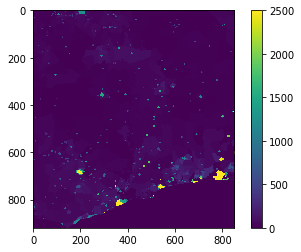

 
Running Ghana (288)
Iteration 1; Current max: 5708 (target: 5422.599999999999)
Increasing window size to 4
Iteration 2; Current max: 5708.0 (target: 5422.599999999999)
Increasing window size to 5
Iteration 3; Current max: 5708.0 (target: 5422.599999999999)
Iteration 4; Current max: 5707.575781250001 (target: 5422.599999999999)
Iteration 5; Current max: 5702.267863859954 (target: 5422.599999999999)
Iteration 6; Current max: 5691.859781976394 (target: 5422.599999999999)
Iteration 7; Current max: 5679.780734642249 (target: 5422.599999999999)
Iteration 8; Current max: 5666.6407037547915 (target: 5422.599999999999)
Iteration 9; Current max: 5653.127344700987 (target: 5422.599999999999)
Iteration 10; Current max: 5639.802405628417 (target: 5422.599999999999)
Iteration 11; Current max: 5626.793481346485 (target: 5422.599999999999)
Iteration 12; Current max: 5614.2199332668 (target: 5422.599999999999)
Iteration 13; Current max: 5602.150240041072 (target: 5422.599999999999)
Iteration 14; Curr

Iteration 113; Current max: 5422.746553391936 (target: 5422.599999999999)
Iteration 114; Current max: 5422.736470132936 (target: 5422.599999999999)
Iteration 115; Current max: 5422.727080626259 (target: 5422.599999999999)
Iteration 116; Current max: 5422.71833714039 (target: 5422.599999999999)
Iteration 117; Current max: 5422.710195227798 (target: 5422.599999999999)
Iteration 118; Current max: 5422.702613498999 (target: 5422.599999999999)
Iteration 119; Current max: 5422.695553412162 (target: 5422.599999999999)
Iteration 120; Current max: 5422.688979077186 (target: 5422.599999999999)
Iteration 121; Current max: 5422.68285707327 (target: 5422.599999999999)
Iteration 122; Current max: 5422.677156279015 (target: 5422.599999999999)
Iteration 123; Current max: 5422.671847714229 (target: 5422.599999999999)
Iteration 124; Current max: 5422.666904392609 (target: 5422.599999999999)
Iteration 125; Current max: 5422.662301184559 (target: 5422.599999999999)
Iteration 126; Current max: 5422.6580146

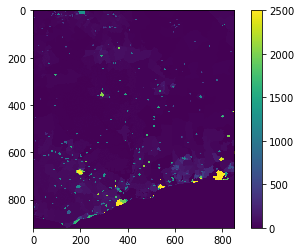

 
Running Benin (204)
Iteration 1; Current max: 12084 (target: 11479.8)
Increasing window size to 4
Iteration 2; Current max: 12084.0 (target: 11479.8)
Iteration 3; Current max: 11928.876041666666 (target: 11479.8)
Iteration 4; Current max: 11788.757552083332 (target: 11479.8)
Iteration 5; Current max: 11695.237404152198 (target: 11479.8)
Iteration 6; Current max: 11632.969302330488 (target: 11479.8)
Iteration 7; Current max: 11586.923551959755 (target: 11479.8)
Iteration 8; Current max: 11554.271036032296 (target: 11479.8)
Iteration 9; Current max: 11531.433723949409 (target: 11479.8)
Iteration 10; Current max: 11515.530566882528 (target: 11479.8)
Iteration 11; Current max: 11504.498685033834 (target: 11479.8)
Iteration 12; Current max: 11496.86008670626 (target: 11479.8)
Iteration 13; Current max: 11491.578031197789 (target: 11479.8)
Iteration 14; Current max: 11487.928507758954 (target: 11479.8)
Iteration 15; Current max: 11485.408392839265 (target: 11479.8)
Iteration 16; Current ma

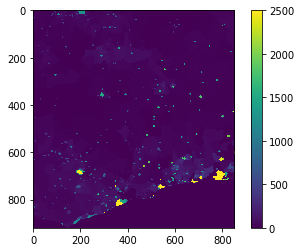

In [22]:
# plot the original one for reference
plt.imshow(pop2000.reshape(shape), clim=(0.0, 2500.0))
plt.colorbar()
plt.show()

for c in countries:
    adjustPopulationNew(np.copy(pop2000), 2010, c, WTP, WUP, urban, areas)
    print(" ")

In [23]:
a = np.array([[0,0,1,0,0,0],
              [0,0,1,0,0,0],
              [0,0,1,0,1,1],
              [0,0,0,0,0,0],
              [0,0,0,0,0,0],])
print(findBoundingBox(a, [1]))
minX, maxX, minY, maxY = findBoundingBox(a, [1])
b = a[minX:maxX,minY:maxY]
print (b)

(0, 3, 2, 6)
[[1 0 0 0]
 [1 0 0 0]
 [1 0 1 1]]
